Handle the dependencies for training and plotting purposes

In [1]:
from keras.layers.convolutional import UpSampling2D
from keras.layers import (
    Dense,
    Activation,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Input,
    Add,
    Reshape
)
from keras.models import (
    Sequential, Model
)
from keras.activations import (
    softmax,
    tanh,
    sigmoid,
    relu
)
%matplotlib inline
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras.backend.tensorflow_backend import set_session
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


Specifies the hyperparameters for trainning  
``Modifies the cell below for tunning the parameters``

In [2]:
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 16
DIS_LR = 0.0002
GEN_LR = 0.0002
DECAY = .99
X_PATH = './datasets/monet2photo/trainA'
Y_PATH = './datasets/monet2photo/trainB'

# Upsampling parameters
NUM_CONV_LAYERS = 2
INIT_FILTER = 16
KERNEL_SIZE = 3
CONV_STRIDES = (2, 2)

# Residual Block parameters
NUM_REPETITIONS = 2
NUM_RES_BLOCKS = 2
RES_STRIDES = (1, 1)

Defines helper functions

In [3]:
""" Return an activation function as needed"""
def activation_func(name):

    def leakyReLu(input_):
        return relu(input_, alpha=.2)
    
    get_custom_objects().update({'leakyReLu': Activation(leakyReLu)})
    
    return {
            'ReLU': relu,
            'tanh': tanh,
            'leakyReLU': leakyReLu,
            'sigmoid': sigmoid,
            'softmax': softmax
    }[name]

""" 
Plot the images inline using matplotlib.

This function takes in 8 pictures where 

X -> Original Picture X 
Y -> Original Picture Y
Y' -> generator_xy(X)
X' -> generator_yx(Y)
Y'' -> generator_xy(X')
X'' -> generator_yx(Y')
X_identical -> generator_yx(X)
Y_identical -> generator_xy(Y)

"""
def plot_images(*images):
    assert(len(images) == 8)
    image_names = ['X', 'Y', "Y'", "X'", "X''", "Y''", 'X_identical', 'Y_identical']
    
    # plt.rcParams['figure.figsize'] = [10, 10]
    
    for i, name in enumerate(image_names):
        image = ((images[i] + 1) / 2 * 255.).astype(int)
        plt.subplot(4, 2, i+1)
        plt.imshow(image)
        plt.title(name)
    
    plt.show()
    

In [4]:
class CycleGAN:
    def __init__(self):
        config = tf.ConfigProto(allow_soft_placement=True)
        config.gpu_options.allow_growth = True
        self.session = tf.Session(config=config)
        set_session(self.session)
        
        with tf.device('/device:GPU:0'):
            self.generator_xy = self.generator()
            self.generator_yx = self.generator()
        
        with tf.device('/device:GPU:1'):
            self.discriminator_x = self.discriminator()
            self.discriminator_y = self.discriminator()
        
            self.xy_Dataset = self.buildDataset()
        
            X, Y     = Input(INPUT_SHAPE)   , Input(INPUT_SHAPE)
            X_, Y_   = self.generator_yx(Y) , self.generator_xy(X)
            X__, Y__ = self.generator_yx(Y_), self.generator_xy(X_)
            X_identity, Y_identity = self.generator_yx(X), self.generator_xy(Y)

            adam_dis = optimizers.Adam(lr=DIS_LR)
            adam_gen = optimizers.Adam(lr=GEN_LR)
        
            self.discriminator_x.compile(loss='mse', optimizer=adam_dis, metrics=['accuracy'])
            self.discriminator_y.compile(loss='mse', optimizer=adam_dis, metrics=['accuracy'])

            self.discriminator_x.trainable = False
            self.discriminator_y.trainable = False

            X_valid, Y_valid = self.discriminator_x(X_), self.discriminator_y(Y_)
        
        with tf.device('/device:GPU:0'):
            # TODO: Figure out the weights of the losses
            self.generators = Model(
                    inputs=[X, Y], 
                    outputs=[X_valid, Y_valid, X_, Y_, X__, Y__, X_identity, Y_identity]
                )

            # The paper suggests using L1 norm for the last four loss functions, try out different settings if it doesn't work
            self.generators.compile(
                loss=['mse']*8,
                loss_weights=[1, 1, 0, 0, 10, 10, 1, 1],
                optimizer=adam_gen
            )

    def buildDataset(self, x_path = X_PATH, y_path = Y_PATH):        
        x_Dataset = tf.data.Dataset.list_files( x_path + '/*.jpg')
        y_Dataset = tf.data.Dataset.list_files( y_path + '/*.jpg')

        x_images = x_Dataset.map(lambda x: tf.image.resize_images(tf.image.decode_jpeg(tf.read_file(x), channels = INPUT_SHAPE[2]), [INPUT_SHAPE[0], INPUT_SHAPE[1]]))
        y_images = y_Dataset.map(lambda x: tf.image.resize_images(tf.image.decode_jpeg(tf.read_file(x), channels = INPUT_SHAPE[2]), [INPUT_SHAPE[0], INPUT_SHAPE[1]]))

        xy_images = tf.data.Dataset.zip((x_images, y_images))
        xy_Dataset = xy_images.batch(BATCH_SIZE)
        return xy_Dataset

    def discriminator(self):
        # Input is an image
        model = Sequential()
        filter_out = self.conv(model, 'leakyReLU')
        # Not sure if a binary discriminator needs residual blocks
        #self._addConvBlock(model, 'leakyReLU', filters=INIT_FILTERS, kernel_size=KERNEL_SIZE, strides=RES_STRIDES, input_layer=True)
        #self.residuals(model, 'leakyReLU', filter_out)
        self._addConvBlock(model, 'leakyReLU', filters=1, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES)
        model.add(Reshape((-1,)))
        model.add(Dense(1))

        return model

        
    def generator(self):
        model = Sequential()
        filter_out = self.conv(model, 'leakyReLU')
        self.residuals(model, 'leakyReLU', filter_out)
        self.deconv(model, 'leakyReLU', filter_out)
        model.add(Activation(activation_func('tanh')))

        return model
        
    # Downsampling - return the final filter size
    def conv(self, model, activations, init_filter=INIT_FILTER, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES):
        self._addConvBlock(model, activations, init_filter, kernel_size, strides, True)

        for i in range(NUM_CONV_LAYERS-1):
            init_filter *= 2
            self._addConvBlock(model, activations, init_filter, kernel_size, strides)

        return init_filter
    
    def deconv(self, model, activations, filters, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES):
        for i in range(NUM_CONV_LAYERS-1):
            filters //= 2
            self._addDeconvBlock(model, activations, filters, kernel_size, strides)

        self._addDeconvBlock(model, activations, INPUT_SHAPE[2], kernel_size, strides)

    def residuals(self, model, activations, filters, kernel_size=KERNEL_SIZE, strides=RES_STRIDES, repetitions=NUM_REPETITIONS):
        for i in range(NUM_RES_BLOCKS):
            self._addResBlock(model, activations, filters, kernel_size, strides, repetitions)

    def _addResBlock(self, model, activations, filters, kernel_size, strides, repetitions):
        for i in range(repetitions):
            self._addConvBlock(model, activations, filters, kernel_size, strides)
        

    def _addDeconvBlock(self, model, activations, filters, kernel_size=KERNEL_SIZE, strides=CONV_STRIDES):
        model.add(BatchNormalization(axis=3))
        model.add(Activation(activation_func(activations)))
        
        model.add(UpSampling2D(size=2))
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=(1,1), padding='same', kernel_initializer='truncated_normal'))
        #model.add(Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides, padding='same'))

    def _addConvBlock(self, model, activations, filters, kernel_size, strides, input_layer=False):
        if not input_layer:
            model.add(BatchNormalization(axis=3))
            model.add(Activation(activation_func(activations)))
            model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='truncated_normal'))
        else:
            model.add(Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', input_shape=INPUT_SHAPE, kernel_initializer='truncated_normal'))

    def train(self):
        # TODO: implements training process
        valid = np.ones((BATCH_SIZE, 1)) * .9
        fake  = np.zeros((BATCH_SIZE, 1))
        
        # self.discriminator_x.summary()
        # self.discriminator_y.summary()
        # self.generators.summary()
        
        for epoch in range(0,10):
            iterator = self.xy_Dataset.make_initializable_iterator()
            (x_next, y_next) = iterator.get_next()
            self.session.run(iterator.initializer)
            batch_i = 0
            
            while True:
                try:
                    # x_train, y_train = np.random.normal(size=[BATCH_SIZE, 256, 256, 3]), np.random.normal(size=[BATCH_SIZE, 256, 256, 3])
                    x_train, y_train = self.session.run([x_next, y_next])
                    
                    if x_train.shape[0] != BATCH_SIZE:
                        break
                    
                    x_train = (x_train / 255.0 - .5) * 2
                    y_train = (y_train / 255.0 - .5) * 2
                    
                    with tf.device('/device:GPU:1'):
                        x_valid, y_valid, x_, y_, x__, y__, x_identity, y_identity = self.generators.predict([x_train, y_train])
                        
                        d_x_real_loss = self.discriminator_x.train_on_batch(x_train, valid)
                        d_x_fake_loss = self.discriminator_x.train_on_batch(x_, fake)
                        d_x_loss = 0.5 * np.add(d_x_real_loss, d_x_fake_loss)

                        d_y_real_loss = self.discriminator_y.train_on_batch(y_train, valid)
                        d_y_fake_loss = self.discriminator_y.train_on_batch(y_, fake)
                        d_y_loss = 0.5 * np.add(d_y_real_loss, d_y_fake_loss)

                        # Total disciminator loss
                        d_loss = 0.5 * np.add(d_x_loss, d_y_loss)
                        
                    
                        # Total generator loss
                        g_loss = self.generators.train_on_batch([x_train, y_train],
                                                                [valid, valid,
                                                                 x_train, y_train,
                                                                 x_train, y_train,
                                                                 x_train, y_train])

                        if batch_i % 10 == 0:
                            plot_images(
                                x_train[0], y_train[0],
                                y_[0], x_[0],
                                x__[0], y__[0],
                                x_identity[0], y_identity[0]
                            )

                            print(
                                'Epoch: ', epoch,
                                'Batch: ', batch_i,
                                'Loss of Discriminator: ', d_loss, 
                                'Loss of Generator G: ', g_loss
                            )

                        batch_i += 1
                    
                
                except tf.errors.OutOfRangeError:
                    print('epoch ' + str( epoch) + ' end.')
                    break

    def test(self, x_test, y_test):
        # TODO: implements evaluation 
        pass

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


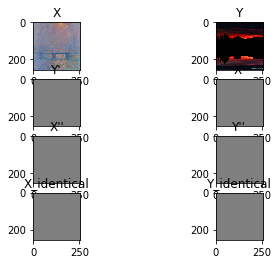

Epoch:  0 Batch:  0 Loss of Discriminator:  [0.6191397 0.5      ] Loss of Generator G:  [10.258784, 1.2797256, 0.4909256, 0.27962816, 0.5063199, 0.2705793, 0.49324405, 0.33186132, 0.5180377]


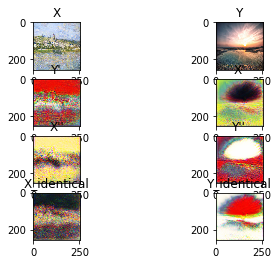

Epoch:  0 Batch:  10 Loss of Discriminator:  [0.2557668 0.40625  ] Loss of Generator G:  [5.9802594, 0.30287454, 0.4900793, 0.34750772, 0.45965862, 0.16590121, 0.24546582, 0.47741163, 0.5962237]


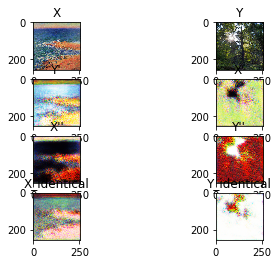

Epoch:  0 Batch:  20 Loss of Discriminator:  [0.1892935 0.390625 ] Loss of Generator G:  [4.457036, 0.35048506, 0.46485412, 0.3246228, 0.45175326, 0.098092824, 0.15295334, 0.5331988, 0.5980361]


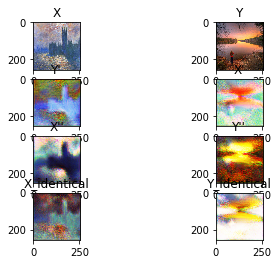

Epoch:  0 Batch:  30 Loss of Discriminator:  [0.22941223 0.421875  ] Loss of Generator G:  [4.229512, 0.57161945, 0.40694636, 0.3791683, 0.48937967, 0.09454874, 0.110992216, 0.5576793, 0.6378575]


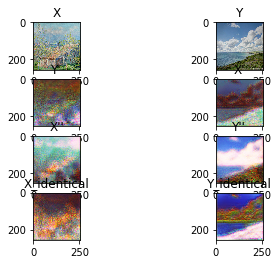

Epoch:  0 Batch:  40 Loss of Discriminator:  [0.14916936 0.453125  ] Loss of Generator G:  [3.6261792, 0.48003137, 0.15674396, 0.3674676, 0.44433329, 0.08712483, 0.098588645, 0.52418566, 0.60808337]


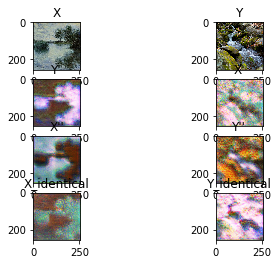

Epoch:  0 Batch:  50 Loss of Discriminator:  [0.17185828 0.46875   ] Loss of Generator G:  [3.6307197, 0.5079882, 0.2523646, 0.45322782, 0.42495853, 0.09381561, 0.089655325, 0.5206202, 0.515037]


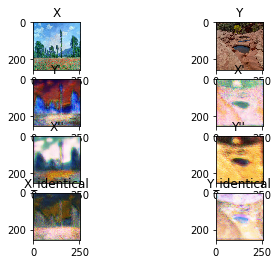

Epoch:  0 Batch:  60 Loss of Discriminator:  [0.15727514 0.421875  ] Loss of Generator G:  [3.3683748, 0.55960876, 0.21752158, 0.3354226, 0.39266986, 0.07830503, 0.089867406, 0.4019652, 0.5075549]
epoch 0 end.


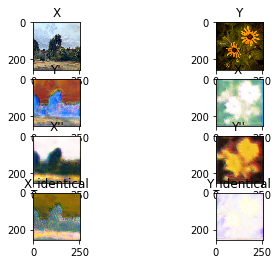

Epoch:  1 Batch:  0 Loss of Discriminator:  [0.11820165 0.4375    ] Loss of Generator G:  [3.5386527, 0.498465, 0.22240493, 0.3121528, 0.44565934, 0.08128409, 0.11390578, 0.40630263, 0.45958132]


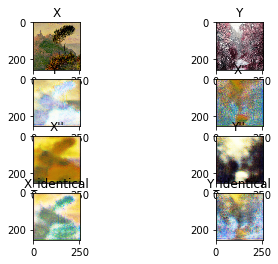

Epoch:  1 Batch:  10 Loss of Discriminator:  [0.14001161 0.4375    ] Loss of Generator G:  [2.9486778, 0.63617027, 0.065840304, 0.3137101, 0.44373238, 0.06548308, 0.08108263, 0.36075568, 0.42025447]


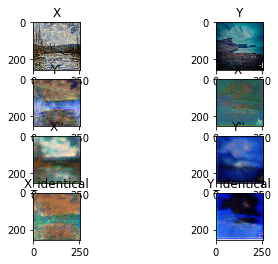

Epoch:  1 Batch:  20 Loss of Discriminator:  [0.08295549 0.5       ] Loss of Generator G:  [3.019606, 0.621005, 0.122433245, 0.3470462, 0.37380666, 0.08555276, 0.06821086, 0.3821261, 0.3564055]


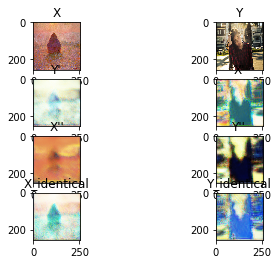

Epoch:  1 Batch:  30 Loss of Discriminator:  [0.12853476 0.421875  ] Loss of Generator G:  [2.3416243, 0.27931008, 0.033909973, 0.33270055, 0.46178907, 0.063024, 0.079634175, 0.27635303, 0.32546937]


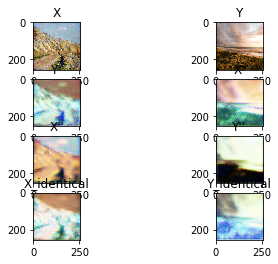

Epoch:  1 Batch:  40 Loss of Discriminator:  [0.07889239 0.5       ] Loss of Generator G:  [2.2150166, 0.39024487, 0.13789275, 0.28296462, 0.44386446, 0.057616457, 0.06350241, 0.21083586, 0.2648546]


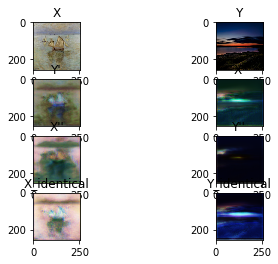

Epoch:  1 Batch:  50 Loss of Discriminator:  [0.14042172 0.421875  ] Loss of Generator G:  [2.1597936, 0.14295433, 0.28927267, 0.26985937, 0.3781466, 0.06151759, 0.070741706, 0.20354892, 0.20142488]


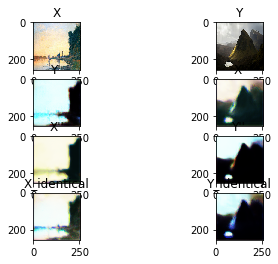

Epoch:  1 Batch:  60 Loss of Discriminator:  [0.1489062 0.4375   ] Loss of Generator G:  [2.2353382, 0.17365822, 0.2300042, 0.3974354, 0.5342579, 0.06281085, 0.08494103, 0.15443037, 0.19972654]
epoch 1 end.


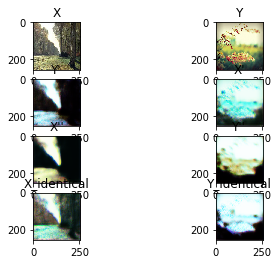

Epoch:  2 Batch:  0 Loss of Discriminator:  [0.19045542 0.375     ] Loss of Generator G:  [1.9318721, 0.18135948, 0.15691173, 0.36566487, 0.45435432, 0.06986201, 0.06160236, 0.13062483, 0.14833255]


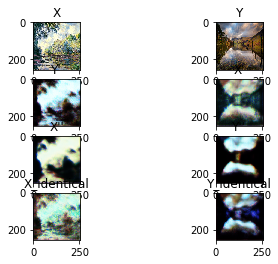

Epoch:  2 Batch:  10 Loss of Discriminator:  [0.11365996 0.5       ] Loss of Generator G:  [1.9221829, 0.09238899, 0.28148308, 0.33951104, 0.4100514, 0.060759284, 0.06740719, 0.11345768, 0.1531885]


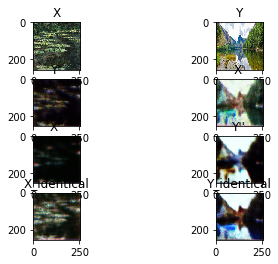

Epoch:  2 Batch:  20 Loss of Discriminator:  [0.09974277 0.4375    ] Loss of Generator G:  [1.8421493, 0.080712646, 0.12050629, 0.3148096, 0.41510284, 0.06163748, 0.074845485, 0.10624217, 0.16985843]


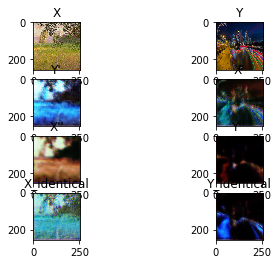

Epoch:  2 Batch:  30 Loss of Discriminator:  [0.08578756 0.5       ] Loss of Generator G:  [1.776846, 0.1710428, 0.07748815, 0.349371, 0.4131723, 0.06617579, 0.058229804, 0.1286515, 0.15560767]


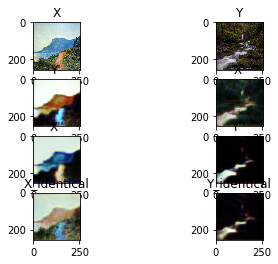

Epoch:  2 Batch:  40 Loss of Discriminator:  [0.08846195 0.484375  ] Loss of Generator G:  [1.5711076, 0.19949238, 0.12706223, 0.32904273, 0.41331545, 0.051175855, 0.051417835, 0.103570834, 0.11504535]


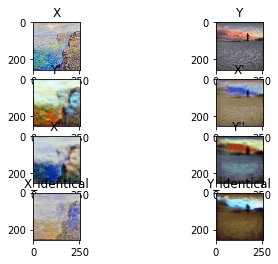

Epoch:  2 Batch:  50 Loss of Discriminator:  [0.08873542 0.46875   ] Loss of Generator G:  [1.5169214, 0.09064989, 0.072112665, 0.3336628, 0.44350484, 0.060790077, 0.04894109, 0.124234155, 0.13261305]


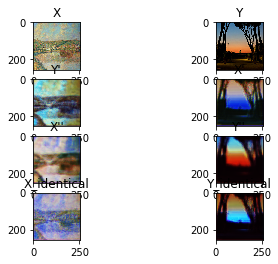

Epoch:  2 Batch:  60 Loss of Discriminator:  [0.13285363 0.4375    ] Loss of Generator G:  [1.6498096, 0.11544223, 0.04805603, 0.32313296, 0.40899798, 0.058179867, 0.061799977, 0.12247366, 0.1640391]
epoch 2 end.


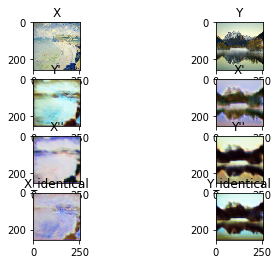

Epoch:  3 Batch:  0 Loss of Discriminator:  [0.14391664 0.46875   ] Loss of Generator G:  [1.3692862, 0.05685875, 0.04954269, 0.36886835, 0.43610582, 0.05713208, 0.047150843, 0.096332446, 0.12372306]


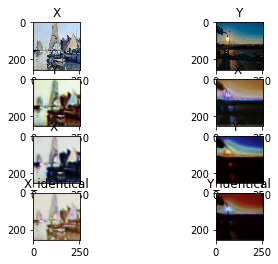

Epoch:  3 Batch:  10 Loss of Discriminator:  [0.10548656 0.46875   ] Loss of Generator G:  [1.4538008, 0.13943341, 0.05198118, 0.24991174, 0.3531465, 0.044944767, 0.056663536, 0.10322291, 0.14308035]


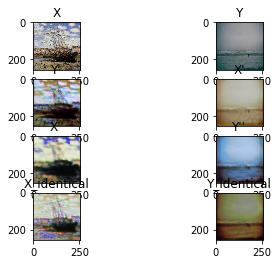

Epoch:  3 Batch:  20 Loss of Discriminator:  [0.11753178 0.484375  ] Loss of Generator G:  [1.4181037, 0.023126282, 0.09750668, 0.35219735, 0.4386524, 0.046531923, 0.057048418, 0.109117806, 0.15254946]


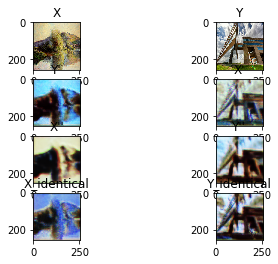

Epoch:  3 Batch:  30 Loss of Discriminator:  [0.11807844 0.484375  ] Loss of Generator G:  [1.4123214, 0.06521747, 0.09230456, 0.28905153, 0.37462467, 0.050670475, 0.050300628, 0.10404962, 0.1410388]


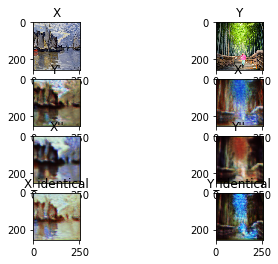

Epoch:  3 Batch:  40 Loss of Discriminator:  [0.07272993 0.5       ] Loss of Generator G:  [1.6696395, 0.08331565, 0.06679988, 0.29679352, 0.46230146, 0.056048747, 0.069641456, 0.11252361, 0.15009828]


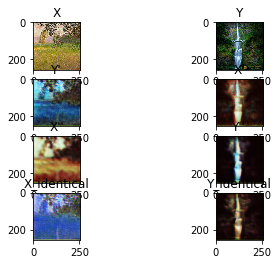

Epoch:  3 Batch:  50 Loss of Discriminator:  [0.07475687 0.46875   ] Loss of Generator G:  [1.4972175, 0.06847503, 0.10046743, 0.3080737, 0.37500882, 0.06302734, 0.047280572, 0.119554386, 0.105641566]


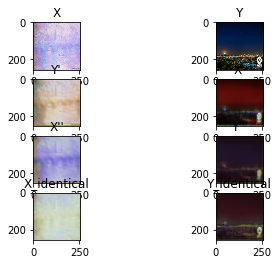

Epoch:  3 Batch:  60 Loss of Discriminator:  [0.10352041 0.5       ] Loss of Generator G:  [1.5177654, 0.07490003, 0.06754073, 0.3863808, 0.46242496, 0.05665545, 0.05688542, 0.10860856, 0.13130726]
epoch 3 end.


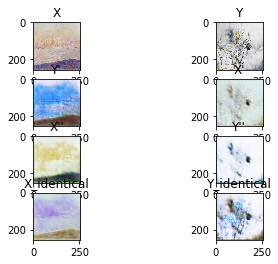

Epoch:  4 Batch:  0 Loss of Discriminator:  [0.11677504 0.46875   ] Loss of Generator G:  [1.5473241, 0.06626174, 0.098990396, 0.37123355, 0.43674025, 0.05549922, 0.05961899, 0.10869457, 0.12219523]


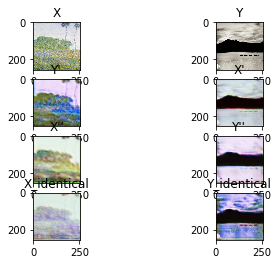

Epoch:  4 Batch:  10 Loss of Discriminator:  [0.05995829 0.46875   ] Loss of Generator G:  [1.4786146, 0.0432753, 0.031077903, 0.3606514, 0.4024021, 0.053214, 0.062979884, 0.10070714, 0.14161523]


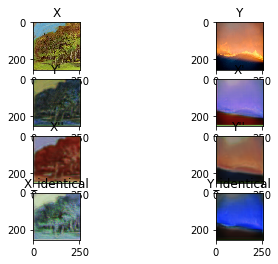

Epoch:  4 Batch:  20 Loss of Discriminator:  [0.0708539 0.484375 ] Loss of Generator G:  [1.5085441, 0.04463055, 0.049265966, 0.37808645, 0.43420535, 0.07195592, 0.04387117, 0.12830672, 0.12806988]


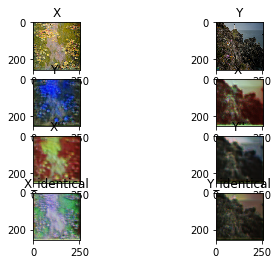

Epoch:  4 Batch:  30 Loss of Discriminator:  [0.07319163 0.5       ] Loss of Generator G:  [1.4616202, 0.034929127, 0.09344967, 0.3742147, 0.3509968, 0.059481807, 0.049855784, 0.11683719, 0.123028375]


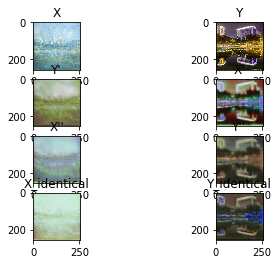

Epoch:  4 Batch:  40 Loss of Discriminator:  [0.06795351 0.46875   ] Loss of Generator G:  [1.4219307, 0.09515764, 0.041293234, 0.31551638, 0.38714772, 0.050409082, 0.05480343, 0.10277741, 0.13057736]


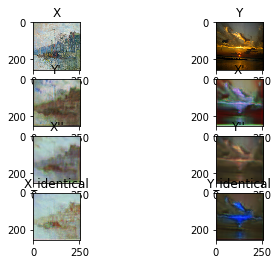

Epoch:  4 Batch:  50 Loss of Discriminator:  [0.07457364 0.5       ] Loss of Generator G:  [1.4307946, 0.1755162, 0.03155722, 0.3304369, 0.40193182, 0.046603963, 0.053137816, 0.106199145, 0.12010434]


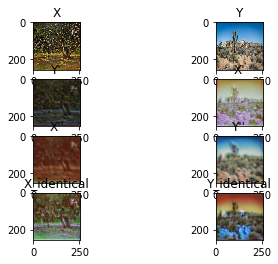

Epoch:  4 Batch:  60 Loss of Discriminator:  [0.0973191 0.484375 ] Loss of Generator G:  [1.5457567, 0.2034511, 0.0554307, 0.2906657, 0.39497367, 0.053510852, 0.052554015, 0.11642604, 0.109800175]
epoch 4 end.


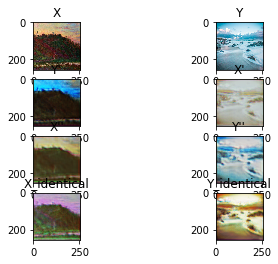

Epoch:  5 Batch:  0 Loss of Discriminator:  [0.10538128 0.46875   ] Loss of Generator G:  [1.6330487, 0.15048775, 0.06794645, 0.31740764, 0.39401168, 0.05569673, 0.06195648, 0.10985271, 0.12822965]


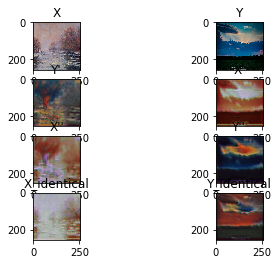

Epoch:  5 Batch:  10 Loss of Discriminator:  [0.23896168 0.34375   ] Loss of Generator G:  [2.2238402, 0.061394252, 0.37279153, 0.34529415, 0.4066909, 0.07542987, 0.07510504, 0.110484764, 0.17382056]


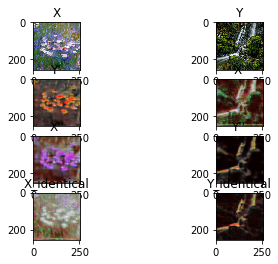

Epoch:  5 Batch:  20 Loss of Discriminator:  [0.13847294 0.453125  ] Loss of Generator G:  [1.6842663, 0.13195238, 0.12132905, 0.31436843, 0.4376376, 0.049854323, 0.06914746, 0.08967791, 0.15128905]


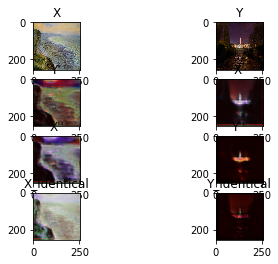

Epoch:  5 Batch:  30 Loss of Discriminator:  [0.15156198 0.40625   ] Loss of Generator G:  [1.4445679, 0.080567025, 0.1232516, 0.30759582, 0.45788884, 0.05188626, 0.050170913, 0.09770165, 0.12247601]


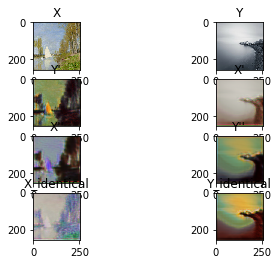

Epoch:  5 Batch:  40 Loss of Discriminator:  [0.11220106 0.46875   ] Loss of Generator G:  [1.3926147, 0.16060062, 0.03111304, 0.3617369, 0.45622587, 0.055106044, 0.04081638, 0.12992945, 0.111747384]


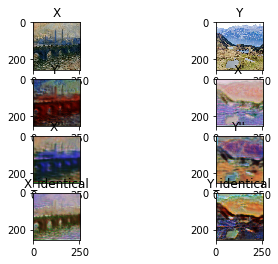

Epoch:  5 Batch:  50 Loss of Discriminator:  [0.09788336 0.484375  ] Loss of Generator G:  [1.6751312, 0.2404744, 0.19698834, 0.32224822, 0.46210313, 0.04614225, 0.05306694, 0.116282955, 0.12929359]


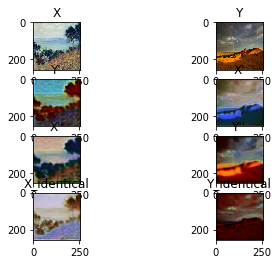

Epoch:  5 Batch:  60 Loss of Discriminator:  [0.11185721 0.453125  ] Loss of Generator G:  [1.732292, 0.12641875, 0.18401739, 0.23422512, 0.37938216, 0.048061114, 0.06868452, 0.12480544, 0.12959425]
epoch 5 end.


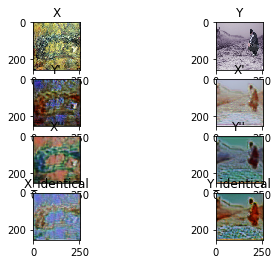

Epoch:  6 Batch:  0 Loss of Discriminator:  [0.10394518 0.421875  ] Loss of Generator G:  [1.8054718, 0.229106, 0.17312115, 0.35753533, 0.47538295, 0.056565277, 0.058057994, 0.14822212, 0.10878978]


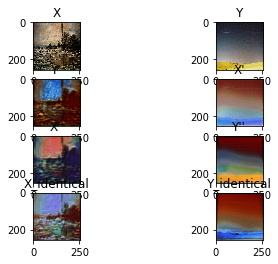

Epoch:  6 Batch:  10 Loss of Discriminator:  [0.12781338 0.40625   ] Loss of Generator G:  [1.6151776, 0.10440348, 0.24597727, 0.3208276, 0.38151073, 0.04540105, 0.057221536, 0.11386883, 0.12470204]


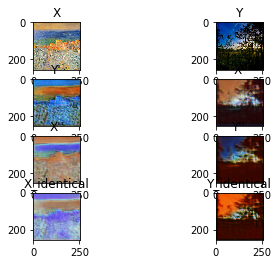

Epoch:  6 Batch:  20 Loss of Discriminator:  [0.09013265 0.484375  ] Loss of Generator G:  [1.6094624, 0.2124785, 0.21224457, 0.3646182, 0.53997177, 0.04469516, 0.049039487, 0.10879056, 0.13860221]


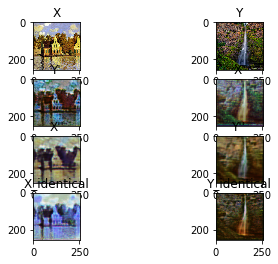

Epoch:  6 Batch:  30 Loss of Discriminator:  [0.12385409 0.40625   ] Loss of Generator G:  [1.5506986, 0.16475406, 0.05079692, 0.32965916, 0.5071286, 0.042487416, 0.06855427, 0.09383805, 0.13089274]


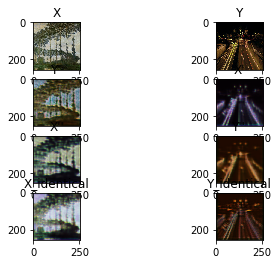

Epoch:  6 Batch:  40 Loss of Discriminator:  [0.12938339 0.484375  ] Loss of Generator G:  [1.2533667, 0.112603396, 0.033633783, 0.31842127, 0.41904634, 0.045754954, 0.04709867, 0.096047744, 0.08254555]


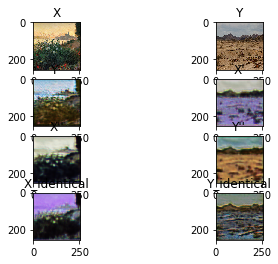

Epoch:  6 Batch:  50 Loss of Discriminator:  [0.11538884 0.453125  ] Loss of Generator G:  [1.2832395, 0.030286955, 0.08420664, 0.32955262, 0.4444749, 0.049846213, 0.046425715, 0.115238406, 0.090788126]


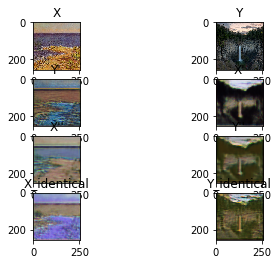

Epoch:  6 Batch:  60 Loss of Discriminator:  [0.10696335 0.453125  ] Loss of Generator G:  [1.4943063, 0.08582623, 0.13204256, 0.35243446, 0.5696185, 0.04784165, 0.0570568, 0.09919339, 0.12825972]
epoch 6 end.


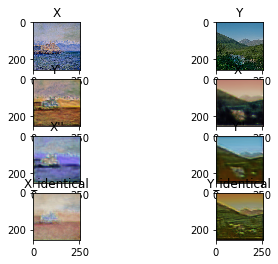

Epoch:  7 Batch:  0 Loss of Discriminator:  [0.10230212 0.4375    ] Loss of Generator G:  [1.4993159, 0.04987839, 0.104037285, 0.35503232, 0.55216205, 0.04665023, 0.06498572, 0.103212535, 0.12582819]


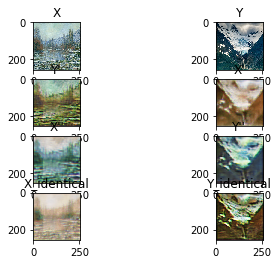

Epoch:  7 Batch:  10 Loss of Discriminator:  [0.09689046 0.484375  ] Loss of Generator G:  [1.5117238, 0.12299335, 0.022107191, 0.31110942, 0.45900238, 0.04962542, 0.06333171, 0.108083054, 0.128969]


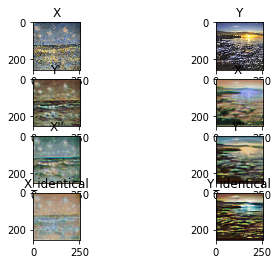

Epoch:  7 Batch:  20 Loss of Discriminator:  [0.10831939 0.390625  ] Loss of Generator G:  [1.5441602, 0.14368469, 0.057667717, 0.31142604, 0.5403615, 0.045881703, 0.061314963, 0.11321912, 0.1576221]


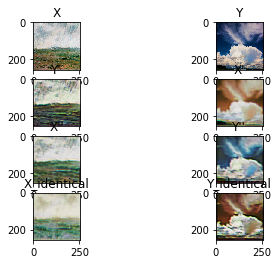

Epoch:  7 Batch:  30 Loss of Discriminator:  [0.11607524 0.40625   ] Loss of Generator G:  [1.6284636, 0.106661804, 0.16616267, 0.29210454, 0.45312452, 0.048481055, 0.06513716, 0.09026757, 0.1291895]


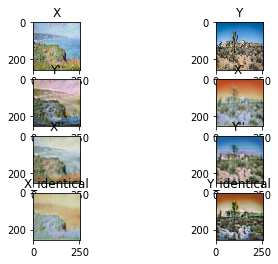

Epoch:  7 Batch:  40 Loss of Discriminator:  [0.10119682 0.5       ] Loss of Generator G:  [1.6778909, 0.18200725, 0.29636773, 0.36203194, 0.47190267, 0.052092664, 0.04679651, 0.11495265, 0.09567144]


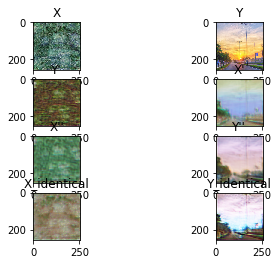

Epoch:  7 Batch:  50 Loss of Discriminator:  [0.11470546 0.453125  ] Loss of Generator G:  [1.7198226, 0.0885701, 0.21724573, 0.29414886, 0.48208824, 0.053565286, 0.06218017, 0.13343348, 0.12311873]


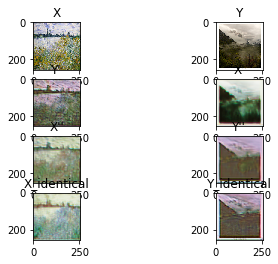

Epoch:  7 Batch:  60 Loss of Discriminator:  [0.08355048 0.484375  ] Loss of Generator G:  [1.6175401, 0.1463815, 0.15721697, 0.31058532, 0.5036243, 0.04835292, 0.057461195, 0.1090661, 0.14673436]
epoch 7 end.


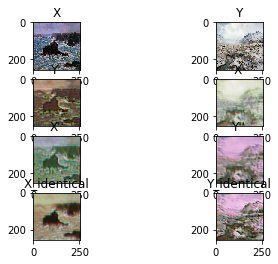

Epoch:  8 Batch:  0 Loss of Discriminator:  [0.07251988 0.484375  ] Loss of Generator G:  [1.2915162, 0.07157481, 0.14114693, 0.25842172, 0.4276423, 0.04121215, 0.04559931, 0.111761644, 0.098918244]


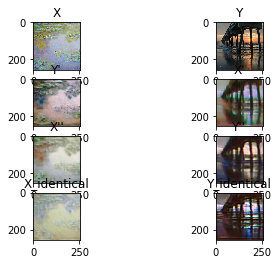

Epoch:  8 Batch:  10 Loss of Discriminator:  [0.17658018 0.375     ] Loss of Generator G:  [1.38752, 0.081339076, 0.13155021, 0.32175434, 0.441972, 0.03817285, 0.057750598, 0.11013187, 0.10526447]


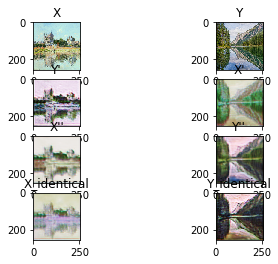

Epoch:  8 Batch:  20 Loss of Discriminator:  [0.0853546 0.453125 ] Loss of Generator G:  [1.316226, 0.041375898, 0.07400846, 0.33925986, 0.4163053, 0.048940346, 0.04847712, 0.115347944, 0.11131898]


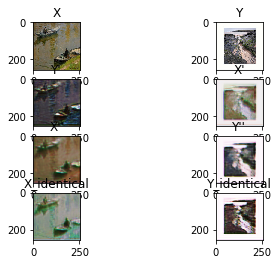

Epoch:  8 Batch:  30 Loss of Discriminator:  [0.09812983 0.4375    ] Loss of Generator G:  [1.4767044, 0.050646145, 0.0876888, 0.32414567, 0.510118, 0.045339692, 0.065596245, 0.11311141, 0.115898766]


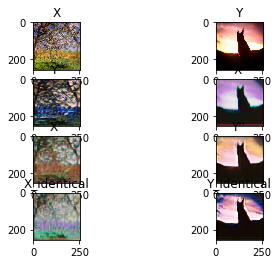

Epoch:  8 Batch:  40 Loss of Discriminator:  [0.11214913 0.4375    ] Loss of Generator G:  [1.5187864, 0.076230936, 0.084308766, 0.29754633, 0.40633306, 0.0584528, 0.050245997, 0.13732705, 0.13393174]


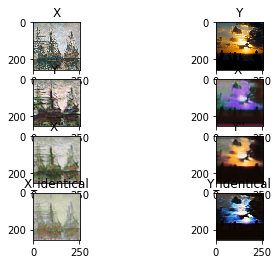

Epoch:  8 Batch:  50 Loss of Discriminator:  [0.12693623 0.421875  ] Loss of Generator G:  [1.3336227, 0.07536873, 0.06648669, 0.314588, 0.4782868, 0.04814976, 0.046361245, 0.115145065, 0.13151222]


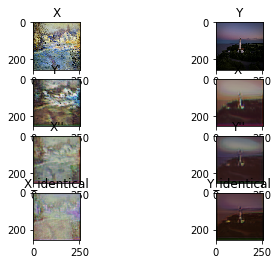

Epoch:  8 Batch:  60 Loss of Discriminator:  [0.17167976 0.4375    ] Loss of Generator G:  [1.3932968, 0.09022758, 0.045719817, 0.31232232, 0.38690063, 0.061517, 0.04141566, 0.120066136, 0.10795664]
epoch 8 end.


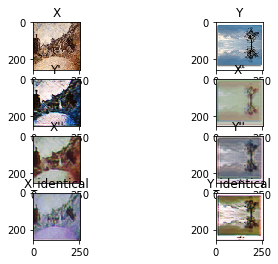

Epoch:  9 Batch:  0 Loss of Discriminator:  [0.08098393 0.453125  ] Loss of Generator G:  [1.4349959, 0.13605538, 0.038226195, 0.27786288, 0.38460612, 0.05170584, 0.04981724, 0.13423675, 0.11124687]


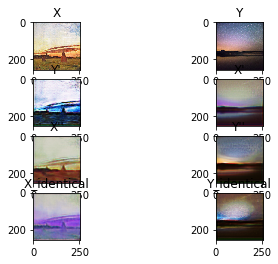

Epoch:  9 Batch:  10 Loss of Discriminator:  [0.12696642 0.5       ] Loss of Generator G:  [1.3717089, 0.05345367, 0.11676908, 0.34511834, 0.4016946, 0.05046875, 0.043460783, 0.13758868, 0.124602124]


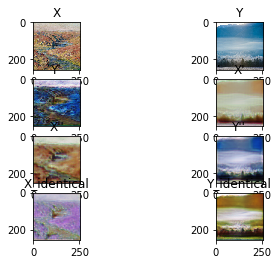

Epoch:  9 Batch:  20 Loss of Discriminator:  [0.15031481 0.484375  ] Loss of Generator G:  [1.5304158, 0.054348685, 0.13066106, 0.31184626, 0.5415078, 0.042304203, 0.06635329, 0.10720302, 0.15162805]


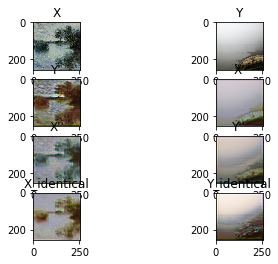

Epoch:  9 Batch:  30 Loss of Discriminator:  [0.08686718 0.5       ] Loss of Generator G:  [1.4759675, 0.08963173, 0.07637811, 0.33807102, 0.4187827, 0.05125847, 0.054753628, 0.10181931, 0.14801751]


In [ ]:
cycleGAN = CycleGAN()
cycleGAN.train()

with tf.device('/device:GPU:1'):
    cycleGAN.generators.save('./conv2_adam_30epoch.h5')

In [ ]:
# TODO Preprocess input images
'''
x_train = np.random.normal(size=[2560, 128, 128, 3])
# y_train = x_train # train tensor for the generator
y_train = np.random.normal(size=[2560, 1]) # train tensor for the discriminator

x_test = np.random.normal(size=[2560, 128, 128, 3])
# y_test = x_test # test tensor for the generator
y_test = np.random.normal(size=[2560, 1]) # test tensor for the discriminator
'''

In [ ]:
x_train = np.random.normal(size=[10, 256, 256, 3])

plot_images(
    x_train[0], x_train[1],
    x_train[2], x_train[3],
    x_train[4], x_train[5],
    x_train[6], x_train[7]
)